In [1]:
import pandas as pd
import numpy as np
np.random.seed(12345)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

In [2]:
def get_df_4wk(df_daily, end_of_week):

    if end_of_week == 'Fri':
        old = pd.read_stata('transformed_data_prices_v19.dta')
    elif end_of_week == 'Tue':
        old = pd.read_stata('transformed_data_physical_v19.dta')
    old['date'] = old[f'date_{end_of_week}']

    df_weekly = df_daily.resample(f'W-{end_of_week.upper()}').mean()
    df_4wk = df_weekly.rolling(4).mean()
    df_4wk = df_4wk.merge(old, on='date')
    df_weekly = df_weekly.merge(old, on='date')
    
    return df_4wk, df_weekly

def get_new2old(end_of_week, n_topics):
    new2old = {}
    new2old['article count_4wk'] = f'artcount_4wk_{end_of_week}'
    new2old['entropy_4wk'] = f'entropy_4wk_{end_of_week}'
    new2old['entropy'] = f'entropy_{end_of_week}'
    for i in range(n_topics):
        new2old[f'Topic {i+1}_4wk'] = f'ftopic{i+1}_4wk_{end_of_week}'
        new2old[f'Topic-Sentiment {i+1}_4wk'] = f'stopic{i+1}_4wk_{end_of_week}'
    return new2old

def get_corr(end_of_week, threshold='2007-07-01'):
    
    df_daily = pd.read_csv('NYtime_daily_level_measures_C_2023.csv')
    n_topics = sum([i.startswith('Topic-Sentiment') for i in df_daily.columns])

    df_daily['date'] = pd.to_datetime(df_daily['date'], format='%Y%m%d')
    df_daily.set_index('date', inplace=True)
    
    new2old = get_new2old(end_of_week, n_topics)
    df_4wk, df = get_df_4wk(df_daily, end_of_week)
    
    corr = pd.DataFrame(index=['all','prior','post'], columns=new2old.keys())
    corr.index.name = end_of_week
    for new, old in new2old.items():
        if new.endswith('4wk'):
            new_prefix = new[:-4]
            df_sub = df_4wk.dropna(subset=[new_prefix, old])
        else:
            df_sub = df.dropna(subset=[new_prefix, old])
        df_prior = df_sub[df_sub['date'] < threshold]
        df_post = df_sub[df_sub['date'] >= threshold]
        corr[new]['all'] = np.corrcoef(df_sub[new_prefix], df_sub[old]).min()
        corr[new]['prior'] = np.corrcoef(df_prior[new_prefix], df_prior[old]).min()
        corr[new]['post'] = np.corrcoef(df_post[new_prefix], df_post[old]).min()
    
    return corr.astype(float)

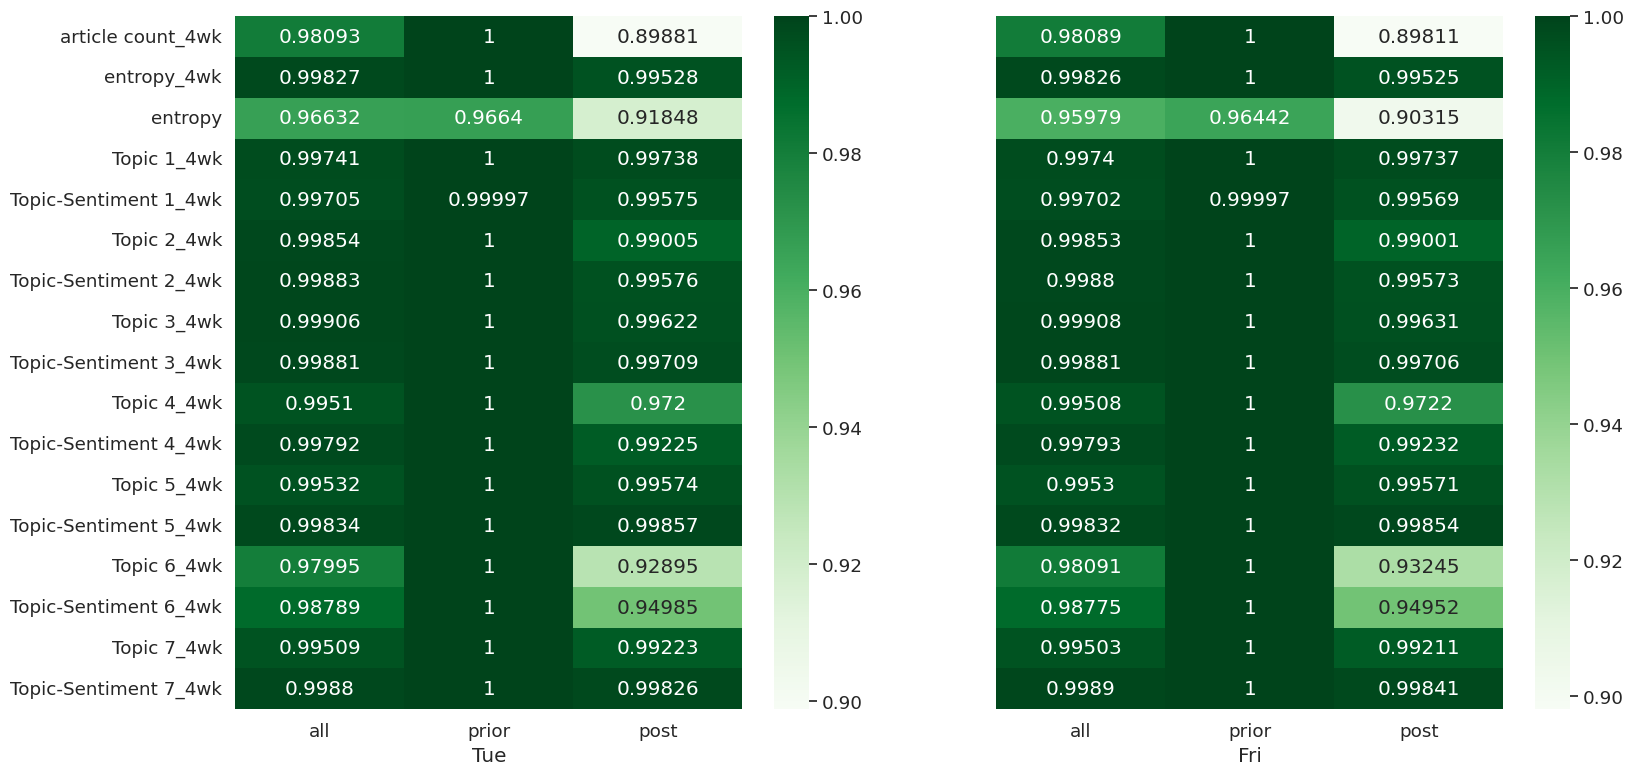

In [3]:
weekdays = ['Tue', 'Fri']
fig, ax = plt.subplots(figsize=(18,9), nrows=1, ncols=len(weekdays))
for i, end_of_week in enumerate(weekdays):
    sns.heatmap(get_corr(end_of_week).T, annot=True, fmt='.5g', cmap='Greens', ax=ax[i]);
    if i!=0:
        ax[i].set_yticklabels([])
plt.savefig('corr.pdf')